<h2> Introduction </h2>
Create a report to summarise tenative analysis of the Titanic dataset using Pandas and Numpy.

The Titanic dataset contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic.

<h2> Possible Questions </h2>
<ul>
<li>What was the effect of gender on survival chances?</li>
<li>Did age effect the chance of survival?</li>
<li>Were more wealthy passengers likely to survive?</li>
<li>Were you more likely to survive if you had no family ties on the ship? </li>
</ul>

<h2> Data Wrangling </h2>
<ul>
<li><b>survival -</b> Survival 	    (0 = No, 1 = Yes)
<li><b>pclass  - </b> Ticket class 	(1 = 1st, 2 = 2nd, 3 = 3rd)
<li><b>sex 	   - </b> Sex 	
<li><b>Age 	   - </b> Age in years 	
<li><b>sibsp   - </b> # of siblings / spouses aboard the Titanic 	
<li><b>parch   - </b> # of parents / children aboard the Titanic 	
<li><b>ticket  - </b>   Ticket number 	
<li><b>fare    - </b>   Passenger fare 	
<li><b>cabin   - </b>   Cabin number 	
<li><b>embarked -</b>	Port of Embarkation
</ul>

<h4> Variable Notes: </h4>

<b>pclass: </b>A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

<b>age:</b> Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

<b>sibsp:</b> The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

<b>parch:</b> The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

(sourced from: https://www.kaggle.com/c/titanic/data)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

titanic_data = pd.read_csv('titanic-data.csv')

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h2> Data Cleanup </h2>

Purpose of this is to declutter dataset, remove any erroneous data such as duplicate rows and fix any issues regarding data formatting.

<h3> Step 1 - Remove Duplicate entires </h3>

In [3]:
print 'Number of duplicate entries: ', titanic_data.duplicated().sum()


Number of duplicate entries:  0


<h3> Step 2 - Declutter dataframe </h3>

Here I only took the series we were interested in.

In [184]:
titanic_data_trimmed = titanic_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Fare'], axis=1)
print titanic_data_trimmed.head()

   Survived  Pclass     Sex   Age  SibSp  Parch
0         0       3    male  22.0      1      0
1         1       1  female  38.0      1      0
2         1       3  female  26.0      0      0
3         1       1  female  35.0      1      0
4         0       3    male  35.0      0      0


<h3> Check data types </h3>

Here I checked the datatype and for any missing data in each entry.

In [5]:
#Check the datatypes and any missing data
print titanic_data_trimmed.info()

print ""

print "MISSING DATA"
print titanic_data_trimmed.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.8+ KB
None

MISSING DATA
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64


It looks like we are missing a lot of age data, time to work out how many males and females missing. This will have to take this into account for further analysis.

In [6]:
missing_age_female = titanic_data_trimmed[(titanic_data_trimmed['Sex']=='female')]['Age'].isnull().values.sum()
missing_age_male   = titanic_data_trimmed[(titanic_data_trimmed['Sex']=='male')]['Age'].isnull().values.sum()
missing_percent = ((missing_age_female + missing_age_male) / float(titanic_data_trimmed['Age'].fillna(1).count())) * 100

print 'Missing age data from: {} males'.format(missing_age_male)
print 'Missing age data from: {} females'.format(missing_age_female)
print 'Missing percent of results {}%'.format(round(missing_percent,2))

Missing age data from: 124 males
Missing age data from: 53 females
Missing percent of results 19.87%


In total approx 20%, <b>117 Age</b> entries are missing, <b>124 of which were males and 53 of which were females. </b> Missing data will affect Q2, Did age effect the chance of survival on the boat?, in this case we will have to drop the missing entries from our dataset as they are treated as zero's when performing operations such as mean.
The missing age data does not effect any other question that has been answered, therefore the trimmed data set is going to be used for analysis further on.

<h2> Data exploration </h2>
<h3> Q1 - What was the effect of gender on survival? </h3>

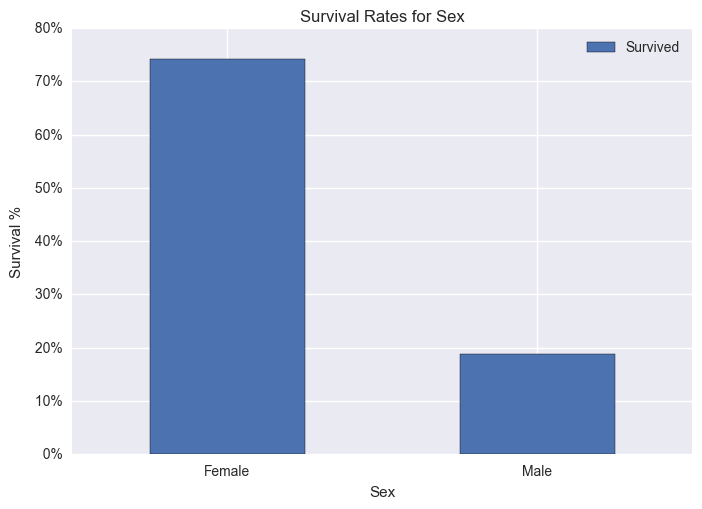

In [130]:
#Function to plot survival rates, group by variable

def capitalize_string(x):
    if isinstance(x, str):
        return x.capitalize()
    return x

def plot_survival(data, variable):
    data = data.groupby(variable).mean().reset_index()
    data.loc[:,variable] = data[variable].apply(capitalize_string)
    
    ax = data.plot(kind='bar', x=variable, y='Survived', legend=True)
    plt.title('Survival Rates for {0}'.format(variable))
    plt.xticks(rotation=0)
    plt.ylabel('Survival %')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    plt.show()

#Group data by sex
plot_survival(titanic_data_trimmed,'Sex')





<h3> Q1 - Summary </h3>
Females have a higher survival rate then males on the boat.

<h3> Q2 - Did age effect the chance of survival on the boat? </h3>
Note: Approx 20% of passenger entries did not contain age data so they have been omitted.

Ideas to compute:
 - Compute measures of central tendancy for age survival rates
 - Split ages into histogram and see survival percentages of different groups
 

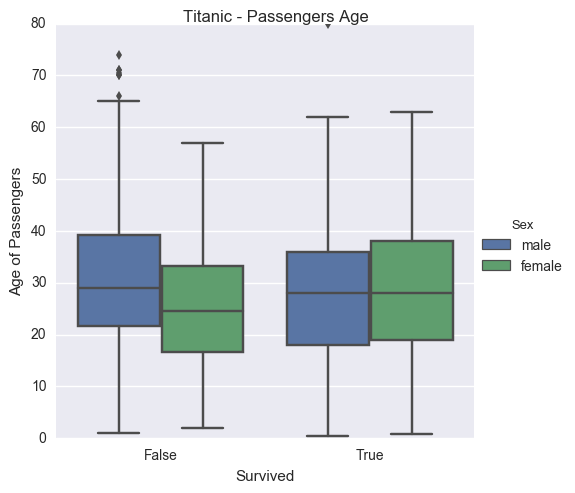

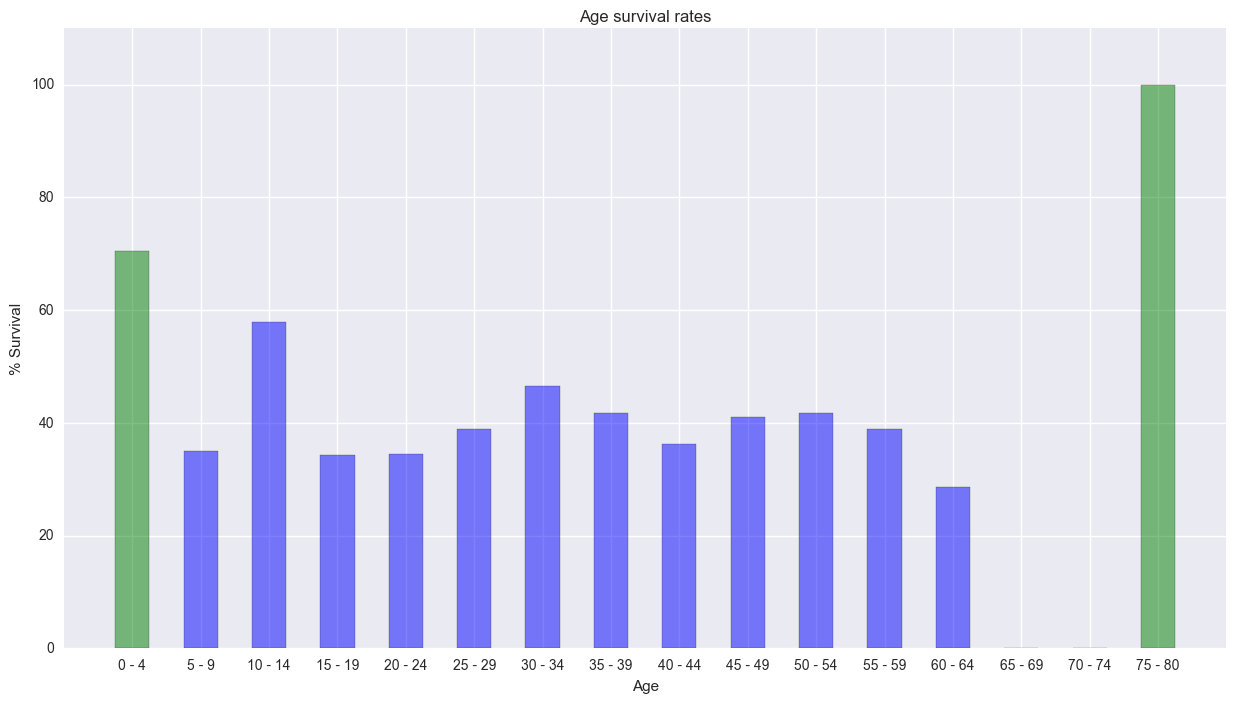

In [182]:
#Average age of person on boat NA's removed
#NA values must be dropped as they are treated as 0's in pandas.
only_with_ages = titanic_data_trimmed.dropna()

#Start bins at 0 to look better
bins = np.arange(0, only_with_ages['Age'].max()+5, 5)

#Add in a column for the binned value
only_with_ages.loc[:,'binned_values'] = pd.cut(only_with_ages['Age'].values, bins=bins)

#Work out survival percentages for our binned groups
survival_percentages = only_with_ages.groupby('binned_values')['Survived'].mean()

#Measures of central tendancy
survival_mean = only_with_ages['Survived'].mean()* 100
survival_std  = only_with_ages['Survived'].std() * 100

#Box plot creation
f = sns.factorplot(x="Survived", y="Age", hue='Sex', data=only_with_ages, kind="box", size=5, aspect=1)

# Create labels
(f.set_axis_labels('Survived', 'Age of Passengers').set_xticklabels(["False", "True"]))

f.fig.suptitle("Titanic - Passengers Age")

plt.show()

#Bar Chart creation
y_val = survival_percentages.values * 100
x_pos = np.arange(len(y_val))

f, ax = plt.subplots(figsize=(15,8))

#Loop through variables to create bar
for x, y in zip(x_pos, y_val):
    #Highlight values that are > 0.5 std
    color = 'green' if (y > survival_mean + (0.5 * survival_std)).sum() == 1 else 'blue'
    bar = ax.bar(x, y, align='center', alpha=0.50, width=0.5, color = color)  

#Create labels
labels = []
for i in range(0, len(bins) - 1):
    #Last bin has 5 steps
    if i == len(bins) - 2:
        labels.append("{} - {}".format(int(bins[i]), int(bins[i + 1])))
        break
    labels.append("{} - {}".format(int(bins[i]), int(bins[i + 1] - 1)))

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_xlim(-1, 16)
ax.set_ylim(0, y_val.max() + 10)
ax.set_title('Age survival rates')
ax.set_ylabel('% Survival')
ax.set_xlabel('Age')


plt.show()




In the graph above I've highlighted values that are more than 0.5 standard deviation above the mean.  It seems like the very elderly, and infants had a higher survival chance.  No one in the range of 65 - 74 had survived on the boat, perhaps they were not deemed "too eldery" to need the extra assistance.


To summarise - <b>It looks like age largely plays no role in the survival rates unless you fall at the extreme ends of the scale.</b>

Below I have double checked bins 65 - 74 contained no survivers.

In [9]:
print only_with_ages[(only_with_ages['Age'] > 64) & (only_with_ages['Age'] < 75)]

     Survived  Pclass   Sex   Age  SibSp  Parch     Fare binned_values
33          0       2  male  66.0      0      0  10.5000      (65, 70]
54          0       1  male  65.0      0      1  61.9792      (60, 65]
96          0       1  male  71.0      0      0  34.6542      (70, 75]
116         0       3  male  70.5      0      0   7.7500      (70, 75]
280         0       3  male  65.0      0      0   7.7500      (60, 65]
456         0       1  male  65.0      0      0  26.5500      (60, 65]
493         0       1  male  71.0      0      0  49.5042      (70, 75]
672         0       2  male  70.0      0      0  10.5000      (65, 70]
745         0       1  male  70.0      1      1  71.0000      (65, 70]
851         0       3  male  74.0      0      0   7.7750      (70, 75]


<h3> Q3 - Were more wealthy passengers likely to survive? </h3>
Our data contains infomation about passengers class, lets see if class affects survival percentages.  My theory is that the higher class passengers had a greater chance of survival.

Class Survival Means
Class 1: 62.96
Class 2: 47.28
Class 3: 24.24


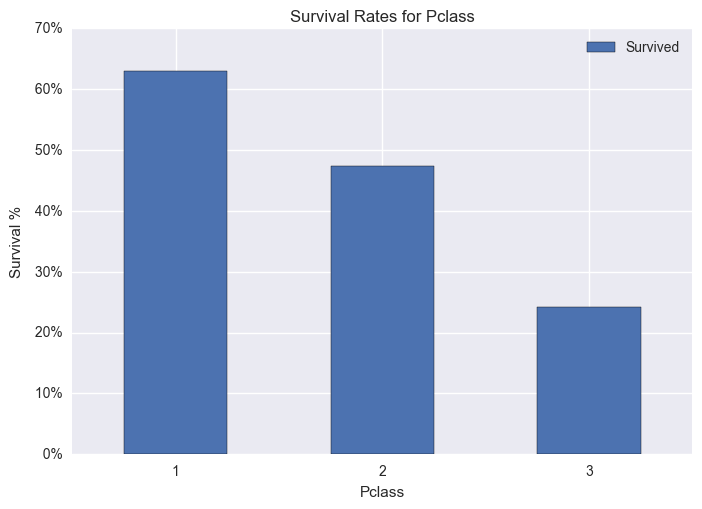

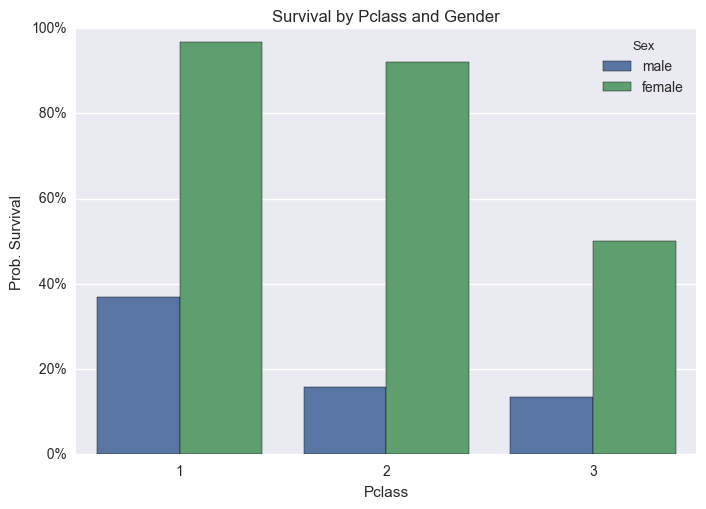

In [131]:
grouped_class_survived = titanic_data_trimmed.groupby(['Pclass'])
class_survival_mean = grouped_class_survived['Survived'].mean() * 100

print "Class Survival Means"
print "Class 1: {}".format(round(class_survival_mean.loc[1],2))
print "Class 2: {}".format(round(class_survival_mean.loc[2],2))
print "Class 3: {}".format(round(class_survival_mean.loc[3],2))
                           
plot_survival(titanic_data_trimmed,'Pclass')



ax = sns.barplot(x="Pclass", y="Survived",hue='Sex', data=titanic_data_trimmed,ci=None)
plt.title('Survival by Pclass and Gender')
plt.ylabel('Prob. Survival')

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

plt.show()

<h3> Q4 - Were you more likely to survive if you had no family ties on the ship?  </h3>
My reasoning behind this question is perhaps if a person had no ties they wouldn't be as obligated to help other  family members.

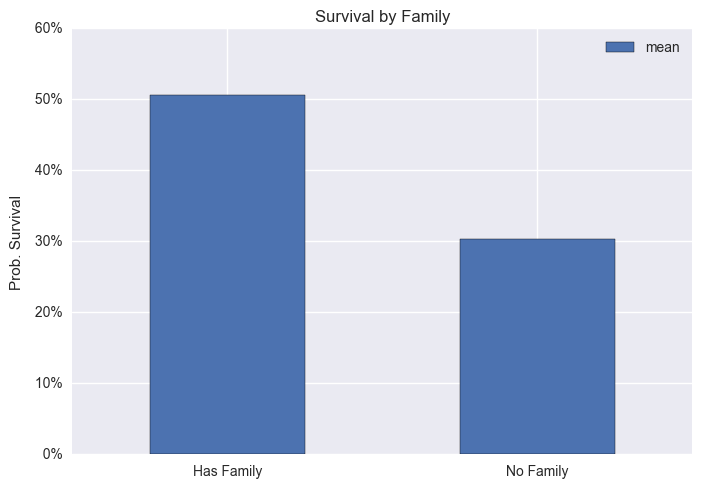


FAMILY STATISTICS


Count of passengers with no family ties: 537
Mean of passengers with no family ties: 30.35%


Count of passengers with family ties: 354
Mean of passengers with family ties: 50.56%


In [355]:
#Create two data sets, one with family data, the other with no family data
df = titanic_data_trimmed.drop(['Pclass','Age','Sex'], axis=1)

#Create a list showing whether in family or not
family = np.where((df['SibSp'] + df['Parch']) >= 1 , 'Has Family', 'No Family')
#Group data according to in family or not
grouped = df.groupby(family)['Survived'].agg(['count', 'mean'])
#plot graph
ax = grouped['mean'].plot(kind='bar', x='index', y='Survived', legend=True)
#Format ticks and labels
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.ylabel('Prob. Survival')
plt.xticks(rotation=0)
plt.title('Survival by Family')
plt.show()

#Statistics
grouped = grouped.reset_index()

no_family_mean = get_val_by_index(grouped, 'No Family', 'mean')
no_family_survived = get_val_by_index(grouped, 'No Family', 'count')
family_survived = get_val_by_index(grouped, 'Has Family', 'count')
family_mean = get_val_by_index(grouped, 'Has Family', 'mean')

def get_val_by_index(data,index,col):
    return data[data['index'] == index][col].values.sum()

    
print ""
print "FAMILY STATISTICS"
print "\n"
print "Count of passengers with no family ties: {}".format(no_family_survived)
print "Mean of passengers with no family ties: {}%".format(round(no_family_mean,4) * 100)
print "\n"
print "Count of passengers with family ties: {}".format(family_survived)
print "Mean of passengers with family ties: {}%".format(round(family_mean,4) * 100)




<h3> Q4 Conclusion </h3>
It seems the oppisite was true, members with family ties had a higher survival rate. I think this means that families often stuck together, meaning a greater chance of survival.

<h2> Conclusion </h2>
Although a tenative analysis has been provided I have explored the role of multiple variables into the chance of survival onboard the Titanic.  Age did not play a major factor in the chance of survival, unless you were at the extreme ends of the scale where chance was higher.  It seemed that the females have a much higher survival chance then men and social class played a role in survival - with higher social classes being more likely to survive.  Those with family ties on the ship also had a higher survival percentage, perhaps they stuck together to increase survival.

There were a few issues in the dataset, such as missing a portion of age data for multiple entires.  These entries were removed from calculations where it would have caused a skew in results.

Moving forward it would be interesting to study the cabin location and survival rates, this would be possible to do with a blueprint of the room locations on the ship.

<h2> References </h2>
- https://www.kaggle.com/c/titanic/data
- https://chrisalbon.com/#Python (Code samples)
- https://www.youtube.com/watch?v=NEhCe4iogGU (FactorPlots)